In [1]:
import os
import yaml
import torch
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from torch.optim import Adam
from autoencoder_cnn import autoencoder
from Diffusion import NoiseScheduler, unet

In [2]:
encoder = torchvision.models.vgg16(pretrained=False) # autoencoder shape
encoder = encoder.features[:11]

/home/maiku/Desktop/DMAD-DDPM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maiku/Desktop/DMAD-DDPM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
BATCH_SIZE = None
EPOCHS = None
URL = None
OUTPUT_PATH = None
DATASET_PATH = None
AUTOENCODER_PATH = None
PRETRAINED_PATH = None
LEARNING_RATE = None
STARTING_CHECKPOINT = None

FREEZE_ENCODER = None
NOISE_COEFFICIENT = None

device = None

In [4]:
configFile = "conf.yaml"

conf = yaml.safe_load(Path(configFile).read_text())

In [5]:
BATCH_SIZE = conf['diffusion']['batch_size']
EPOCHS = conf['diffusion']['epochs']
URL = conf['diffusion']['webhook']
OUTPUT_PATH = conf['diffusion']['output_path']
DATASET_PATH = conf['diffusion']['dataset_path']
AUTOENCODER_PATH = conf['diffusion']['model_input']
STEPS = conf['diffusion']['forward_steps']
STARTING_CHECKPOINT = conf['diffusion']['starting_checkpoint']
LEARNING_RATE = conf['diffusion']['learning_rate']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


In [6]:
model = autoencoder(encoder)
model.load_state_dict(torch.load(AUTOENCODER_PATH))
AUTOENCODER_PATH

'out_ft_reduced/ae_IST_MDB_200.pth'

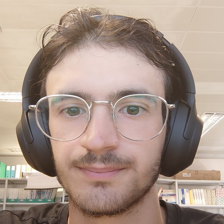

In [7]:
img = Image.open('../not_me.png').convert("RGB")
img = img.resize([224, 224])

img



In [18]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)
mse = nn.MSELoss().to(device)

In [8]:
img = torchvision.transforms.ToTensor()(img).unsqueeze(0)

img.shape


#print(img[0].shape)

torch.Size([1, 3, 224, 224])

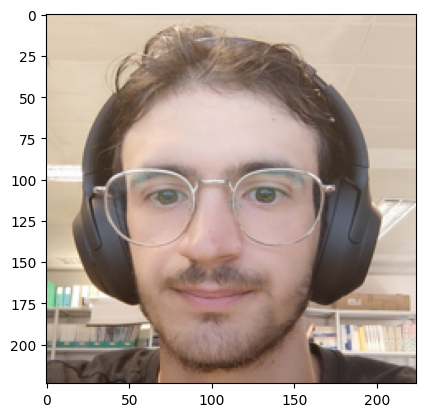

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img[0].permute(1, 2, 0)) ;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014198709..1.013887].


Loss: 0.13921214640140533


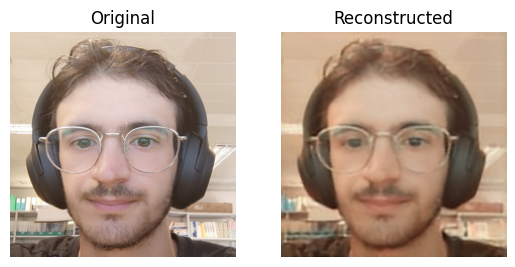

In [23]:

model.eval()
test1 = model(img) ;


fig,axs = plt.subplots(1,2) ; 
axs[0].imshow(img[0].detach().cpu().permute(1,2,0))
axs[0].set_title("Original")
axs[0].axis("off")
axs[1].imshow(test1[0].detach().cpu().permute(1,2,0))
axs[1].set_title("Reconstructed")
axs[1].axis("off")

loss = mse(test1, img) + (1 - ssim(test1, img))
print(f"Loss: {loss.item()}")

In [11]:
# https://github.com/CompVis/latent-diffusion

In [12]:
class demorpher(nn.Module):
    def __init__(self, autoencoder, diffusion, noise_steps, noise_start, noise_end):
        super(self).__init__()
        self.encoder = autoencoder.get_encoder()
        self.decoder = autoencoder.get_decoder()

        self.noise_steps = noise_steps

        self.noise_schedule = NoiseScheduler(noise_start, noise_end, noise_steps)
        self.latent_unet = diffusion
        

    def forward(self, img_A, img_ID):

        z_a = self.encoder(img_A)
        z_id = self.encoder(img_ID)

        # z_id = self.noise_schedule.add_noise(z_id,z_a, self.noise_steps - 1) # totally noised image (might not be necessary, i already have z_a!)

        z_out = self.latent_unet.forward(z_id, self.noise_steps - 1)
        # branch A: denoising ...
        for t in reversed(range(self.noise_steps) - 2): #one step is already done
            noise_pred = self.latent_unet.forward(z_out, t) 
        
        # branch B: image reconstruction
        z_out = self.decoder(z_out)

        return z_out

    def get_unet(self):
        return self.latent_unet

    def get_decoder(self):
        return self.decoder
    
    def freeze_unet(self, Freeze = True):
        for param in self.latent_unet.parameters():
            param.requires_grad = not Freeze

In [ ]:
def evaluate_epoch(model,dataset,device):
    model.eval()
    print("~~~ evaluating ~~~")
    ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)
    mse = nn.MSELoss().to(device)
    running_vloss = 0.0

    with torch.no_grad():
        for img in tqdm(dataset):
            img = img.to(device)
            out = model(img).to(device)
            vloss = 1 - ssim(out, img) + mse(out, img)
            running_vloss += vloss
    return running_vloss / len(dataset)

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [ ]:
if STARTING_CHECKPOINT is not None and STARTING_CHECKPOINT > 0:
    model.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f"demorph_{STARTING_CHECKPOINT}.pth")))
    print(f"Loaded model from checkpoint {OUTPUT_PATH}/demorph_{STARTING_CHECKPOINT}.pth")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

In [ ]:

diffusion_model = unet(1,[32,64,128,256],[256,256,128],[128,64,32,16], [True, True, False])


def train_diffusion(model, train_ds, test_ds, device):
    
    model.train()
    early_stopper = EarlyStopper(patience=5, min_delta=0.0001)

    # Create the noise scheduler
    scheduler = NoiseScheduler( noise_start=0.01,
                                noise_end=0.15,
                                steps=STEPS)
    scheduler.to(device)
    epoch_losses = []
    eval_losses = []

    model.freeze_encoder(True)
    model.freeze_decoder(True)
    model.freeze_unet(False)
    model.freeze_batchNorm(True)

    mse = nn.MSELoss().to(device)

    learning_rate = LEARNING_RATE
    # Specify training parameters
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if not os.path.exists(OUTPUT_PATH):
        os.mkdir(OUTPUT_PATH)


    for epoch_idx in range(EPOCHS):
        losses = []
        if device.type == 'cuda':
             torch.cuda.empty_cache()
        for im_a,im_id,im_target in tqdm(train_ds):
            optimizer.zero_grad()
            im_a = im_a.float().to(device)
            im_id = im_id.float().to(device)
            im_target = im_target.float().to(device)

            latent_a = model.encoder(im_a) # * time noise (?)
            latent_id = model.encoder(im_id)
            latent_target = model.encoder(im_target)


            t = torch.randint(0, STEPS, (im_a.shape[0],)).to(device)
            
            # Add noise to images according to timestep (forse no)
            Z_a = latent_a * scheduler.get_noise(t, latent_a.shape)
            z_a_TARGET = Z_a * NOISE_COEFFICIENT
            
            Z_out_t = latent_id + Z_a



            # branch A: denoising ...
            noise_pred = model.get_unet()(Z_out_t, t)

            loss = mse(noise_pred, z_a_TARGET)

            losses.append((loss.item()))
            loss.backward()
            optimizer.step()
        
        epoch_losses.append(np.mean(losses))

        # Evaluate model
        eval_loss = evaluate_epoch(model, test_ds)

        result = ('Finished epoch:{} | Loss : {:.5f} | Learning Rate: {} | Eval loss: {:.5f}'.format(
            STARTING_CHECKPOINT + epoch_idx + 1,
            np.mean(epoch_losses),
            learning_rate,
            eval_loss
        ))

        # send_webHook(URL, result)
        print(result)
        with open(os.path.join(OUTPUT_PATH, 'losses.txt'), 'a') as f:
            f.write(result + '\n')
        if (epoch_idx + 1) % 5 == 0 or epoch_idx == EPOCHS - 1:
            torch.save(model.state_dict(), os.path.join(OUTPUT_PATH,
                                                    "diffusion_{}.pth".format(STARTING_CHECKPOINT + epoch_idx + 1)))
        if early_stopper.early_stop(eval_loss):
            print('Early stopping')
            


In [ ]:
ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)

In [13]:





def loss_A(target_latent, noise_pred):
    return nn.MSELoss()(target_latent, noise_pred) 

def loss_B(im_target, img_pred):
    # to edit 
    return 0.3 * nn.MSELoss()(im_target, img_pred) + 0.7 * (1 - ssim(im_target, img_pred))

def train(model : demorpher, train_data, test_data):
    
    # Create the early stopper
     #handmade move 
    
    # Create the dataset ...



    model.train()
    model.freeze_encoder()

    # Create output directories

    

    
    # Run training
    

            

        
    
    print('Done Training ...')

Using device: cuda
